### Imports and function definitions

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import lightkurve as lk
from scipy.optimize import curve_fit

def linear_func(x, a, b):
    """
    A simple linear trend for detrending.
    ----------
    Parameters:
        x (numpy array): x-values
        a (float): slope
        b (float): intercept
    ----------
    Returns:
        y (numpy array): linear function of x
    """
    return a*x + b

def stitch(lc_collection): 
    """
    Linearly detrend each "quarter" (interval of observing) of the data, 
    and combine them together. We do this to correct for offsets between quarters 
    and linear systmatics within each quarter. These are instrumental effects.
    ----------
    Parameters:
        lc_collection (lightcurve collection): the collection of quarters of lightcurve
                data returned by the Lightkurve query.
    ----------
    Returns:
        tot_time (numpy array): stitched time values
        tot_flux (numpy array): stitched and detrended flux values
        tot_flux_err (numpy array): stitched flux error values
        tot_qual (numpy array): stitched data quality flag values
    """
    tot_time = np.zeros(0) # to store concatenated arrays
    tot_flux = np.zeros(0)
    tot_flux_err = np.zeros(0)
    tot_qual = np.zeros(0)
    for i in range(len(lc_collection)):
        lc = lc_collection[i]
        flux = lc.flux.value
        time = lc.time.value
        flux_err = lc.flux_err.value
        qual = lc.quality
        rel_flux_err = flux_err/flux
        nan_mask = np.invert(np.isnan(flux))
        
        # Fit and remove linear trend
        popt, pcov = curve_fit(linear_func, time[nan_mask], flux[nan_mask])
        linear_trend = linear_func(time, *popt) # evaluate over the whole interval
        norm = flux / linear_trend
        
        tot_time = np.hstack([tot_time, time])
        tot_flux = np.hstack([tot_flux, norm])
        tot_flux_err = np.hstack([tot_flux_err, rel_flux_err])
        tot_qual = np.hstack([tot_qual, qual])
        
    return tot_time, tot_flux, tot_flux_err, tot_qual

### Download an example lightcurve

In [11]:
star_name = 'Kepler-45' # this is the name of the target star 
obs_type = 'Kepler' # this is the name of the mission which took the data
search_result = lk.search_lightcurve(star_name, author=obs_type, cadence='long') # query database 
lc_collection = search_result.download_all() # download all quarters of lightcurve data for this star
time, flux, flux_err, quality = stitch(lc_collection)

# flag data for quailty issues
good_data_flag = (quality == 0) * (flux_err > 0) * (np.isfinite(time)) * (np.isfinite(flux)) * (np.isfinite(flux_err))  

### Plot the example lightcurve
Note that flux values represent the amount of light we record from the star at each timestep, and the time units are Barycentric Julian Date which is essentially just the number of days since a certain start day. 

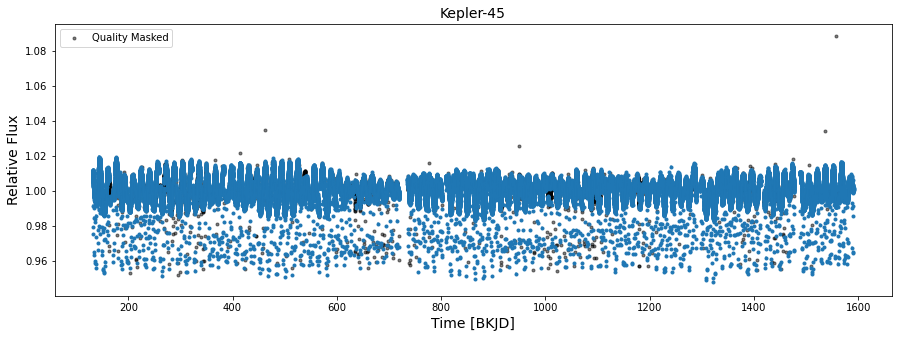

In [16]:
fs = 14
plt.figure(figsize = [15,5])
plt.plot(time[np.invert(good_data_flag)], flux[np.invert(good_data_flag)], '.', color = 'k', alpha = 0.5, label = 'Quality Masked')
plt.plot(time[good_data_flag], flux[good_data_flag], '.', color = 'C0')#, alpha = 0.5)#, label = 'my stitching')
plt.errorbar(time[good_data_flag], flux[good_data_flag], yerr = flux_err[good_data_flag], ls = 'None', color = 'C0', alpha = 0.5)
plt.title(star_name, fontsize = fs)
plt.xlabel('Time [BKJD]', fontsize = fs)
plt.ylabel('Relative Flux', fontsize = fs)
plt.legend(fontsize = fs - 4)

### Now let's download several so we can demonstrate how they vary

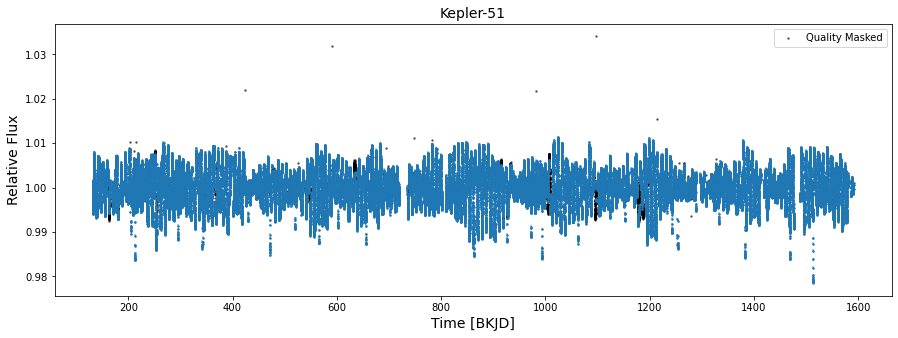

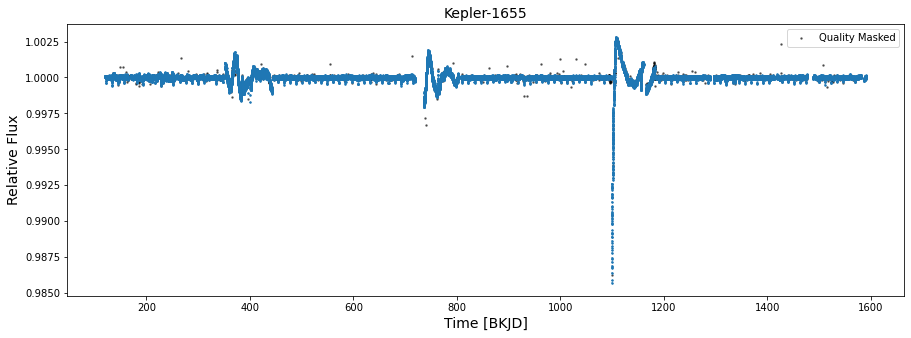

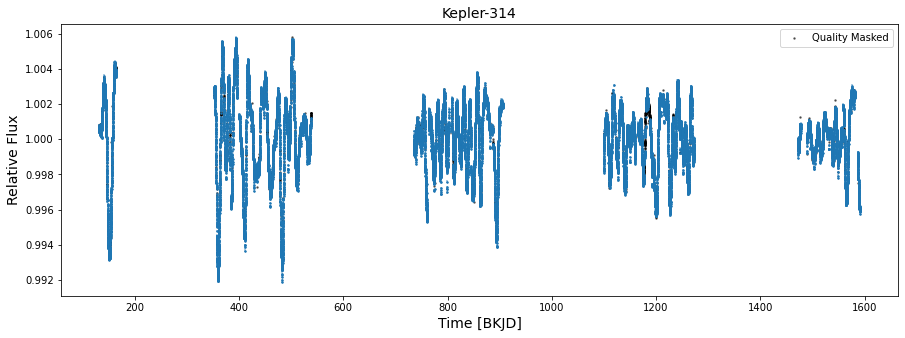

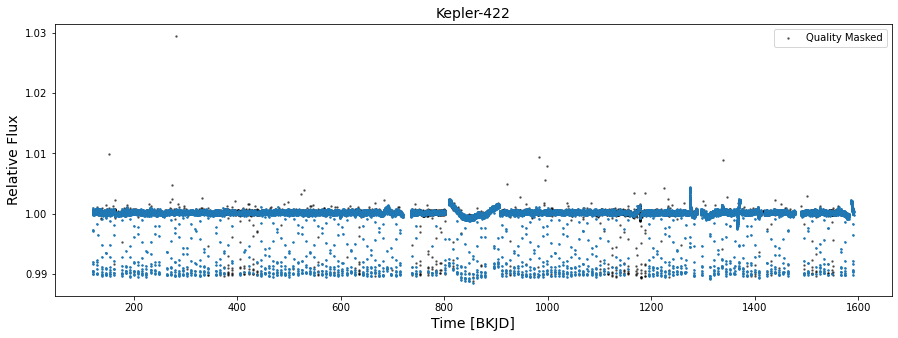

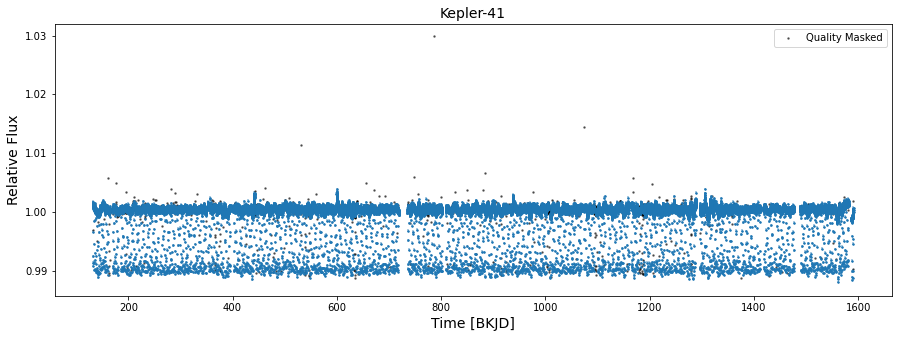

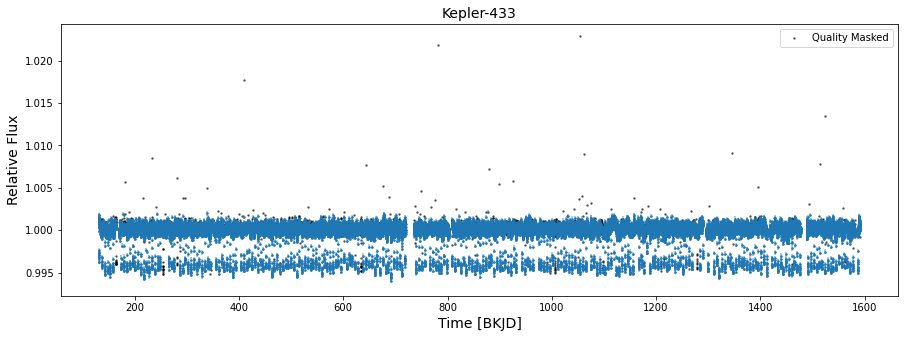

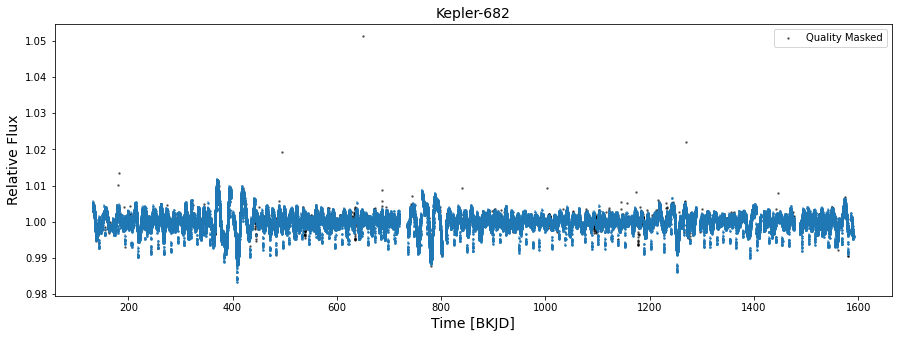

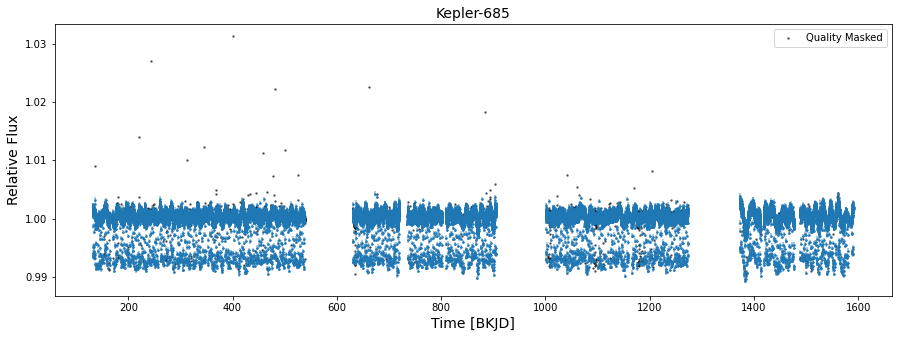

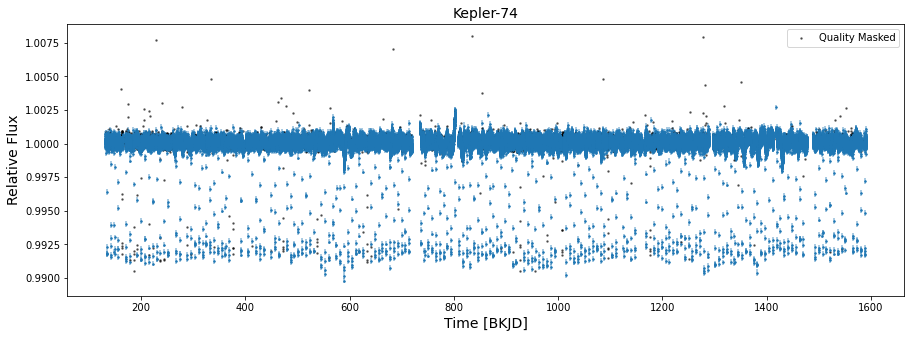

In [20]:
names = ['Kepler-51', 'Kepler-1655', 'Kepler-314', 'Kepler-422', 'Kepler-41', 'Kepler-433', 'Kepler-682', 'Kepler-685', 'Kepler-74'] 
obs_type = 'Kepler'
for name in names:
    search_result = lk.search_lightcurve(name, author=obs_type, cadence='long') 
    lc_collection = search_result.download_all() 
    time, flux, flux_err, quality = stitch(lc_collection)
    good_data_flag = (quality == 0) * (flux_err > 0) * (np.isfinite(time)) * (np.isfinite(flux)) * (np.isfinite(flux_err)) 
    fs = 14
    ms = 3
    plt.figure(figsize = [15,5])
    plt.plot(time[np.invert(good_data_flag)], flux[np.invert(good_data_flag)], '.', ms = ms, color = 'k', alpha = 0.5, label = 'Quality Masked')
    plt.plot(time[good_data_flag], flux[good_data_flag], '.', ms = ms, color = 'C0')#, alpha = 0.5)#, label = 'my stitching')
    plt.errorbar(time[good_data_flag], flux[good_data_flag], yerr = flux_err[good_data_flag], ls = 'None', color = 'C0', alpha = 0.5)
    plt.title(name, fontsize = fs)
    plt.xlabel('Time [BKJD]', fontsize = fs)
    plt.ylabel('Relative Flux', fontsize = fs)
    plt.legend(fontsize = fs - 4)